# Data Prepartion

In [730]:
# !pip install xgboost
# !pip install missingno
# !pip install scikit-learn
# !pip install sweetviz
# !pip install -U imbalanced-learn

# Import Libraries

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import missingno as msno
import sweetviz as sv
import pickle
import warnings
warnings.filterwarnings("ignore") 

from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

# Get the Data
Use pandas to read csv file as a dataframe

In [263]:
df = pd.read_csv("C:/Users/micha/OneDrive - Open University of Israel/שולחן העבודה/healthcare-dataset-stroke-data.csv")
df2 = pd.read_csv("C:/Users/micha/OneDrive - Open University of Israel/שולחן העבודה/healthcare-dataset-stroke-data.csv")

In [264]:
df.shape

(5110, 12)

In [265]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# EDA (Explanatory Data Analysis)

In [266]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [268]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [269]:
df.drop(columns=['id'], axis=1, inplace=True)

In [270]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [271]:
df['age'] = df['age'].astype(int)

In [272]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(col)
        print(df[col].unique())

gender
['Male' 'Female' 'Other']
ever_married
['Yes' 'No']
work_type
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type
['Urban' 'Rural']
smoking_status
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


### Chi-Square 

Segnificant relations between categorial avariables

In [273]:
df_categorical = df[['gender', 'hypertension', 'heart_disease', 'ever_married',
                     'work_type', 'Residence_type', 'smoking_status']]

variable_names = []
chi2_p_values = []

for var in df_categorical:
    contingency_table = pd.crosstab(df[var], df['stroke'])
    
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    variable_names.append(var)
    chi2_p_values.append(p)

chi2_results = pd.DataFrame({'Categorical Variable': variable_names, 'Chi-Square p-value': chi2_p_values})

chi2_results = chi2_results.sort_values(by='Chi-Square p-value')

print(chi2_results)
df.shape

  Categorical Variable  Chi-Square p-value
2        heart_disease        2.088785e-21
1         hypertension        1.661622e-19
3         ever_married        1.638902e-14
4            work_type        5.397708e-10
6       smoking_status        2.085400e-06
5       Residence_type        2.983317e-01
0               gender        7.895491e-01


(5110, 11)

In [274]:
label_encoder = LabelEncoder()
df['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)


Label Mapping:
{'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}


In [275]:
label_encoder = LabelEncoder()
df['work_type'] = label_encoder.fit_transform(df['work_type'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'Govt_job': 0, 'Never_worked': 1, 'Private': 2, 'Self-employed': 3, 'children': 4}


In [276]:
# No = 0, Yes = 1
df['ever_married'].replace({'No': 0,
                   'Yes': 1}, inplace = True)

In [277]:
# Urban = 0, Rural = 1
df['Residence_type'].replace({'Urban': 0,
                   'Rural': 1}, inplace = True)

In [278]:
df = pd.get_dummies(df, columns=['gender'])

In [279]:
def categorize_avg_glucose_level(avg_glucose_level):
    if 70 <= avg_glucose_level <= 100:
        return 'Normal'
    elif 100 < avg_glucose_level <= 125:
        return 'Impaired Glucose'
    else: 
        return 'Diabetic'


df['avg_glucose_category'] = df['avg_glucose_level'].apply(categorize_avg_glucose_level)

avg_glucose_level_category_dummies = pd.get_dummies(df['avg_glucose_category'], prefix='avg_glucose_level')

df = pd.concat([df, avg_glucose_level_category_dummies], axis=1)

df.drop(columns=['avg_glucose_level', 'avg_glucose_category'], inplace=True)

### KNN - 'BMI'

In [280]:
imputer = KNNImputer(n_neighbors=3)
df= pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [281]:
df.isnull().sum()

age                                   0
hypertension                          0
heart_disease                         0
ever_married                          0
work_type                             0
Residence_type                        0
bmi                                   0
smoking_status                        0
stroke                                0
gender_Female                         0
gender_Male                           0
gender_Other                          0
avg_glucose_level_Diabetic            0
avg_glucose_level_Impaired Glucose    0
avg_glucose_level_Normal              0
dtype: int64

In [282]:
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi <= 24.9:
        return 'Normal Weight'
    elif 25 <= bmi <= 29.9:
        return 'Overweight'
    else: 
        return 'Obesity'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)

df_dummies = pd.get_dummies(df['bmi_category'], prefix='bmi')

df = pd.concat([df, df_dummies], axis=1)

df.drop(columns=['bmi', 'bmi_category'], axis=1, inplace=True)


In [283]:
df.head()

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,gender_Female,gender_Male,gender_Other,avg_glucose_level_Diabetic,avg_glucose_level_Impaired Glucose,avg_glucose_level_Normal,bmi_Normal Weight,bmi_Obesity,bmi_Overweight,bmi_Underweight
0,67.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1,0,0
1,61.0,0.0,0.0,1.0,3.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0
2,80.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,0
3,49.0,0.0,0.0,1.0,2.0,0.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0
4,79.0,1.0,0.0,1.0,3.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0


In [284]:
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = df[col].astype(int)

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   age                                 5110 non-null   int32
 1   hypertension                        5110 non-null   int32
 2   heart_disease                       5110 non-null   int32
 3   ever_married                        5110 non-null   int32
 4   work_type                           5110 non-null   int32
 5   Residence_type                      5110 non-null   int32
 6   smoking_status                      5110 non-null   int32
 7   stroke                              5110 non-null   int32
 8   gender_Female                       5110 non-null   int32
 9   gender_Male                         5110 non-null   int32
 10  gender_Other                        5110 non-null   int32
 11  avg_glucose_level_Diabetic          5110 non-null   int32
 12  avg_gl

In [286]:
df.corr()

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,gender_Female,gender_Male,gender_Other,avg_glucose_level_Diabetic,avg_glucose_level_Impaired Glucose,avg_glucose_level_Normal,bmi_Normal Weight,bmi_Obesity,bmi_Overweight,bmi_Underweight
age,1.000000,0.276303,0.263668,0.679181,-0.362146,-0.014169,0.265595,0.245128,0.028026,-0.027726,-0.010642,0.147288,-0.073512,-0.082202,-0.241568,0.247790,0.175352,-0.385497
hypertension,0.276303,1.000000,0.108306,0.164243,-0.051761,0.007913,0.111038,0.127904,-0.021143,0.021275,-0.004597,0.102928,-0.029189,-0.074946,-0.103908,0.146718,-0.013573,-0.083015
heart_disease,0.263668,0.108306,1.000000,0.114644,-0.028023,-0.003092,0.048460,0.134914,-0.085617,0.085717,-0.003343,0.089828,-0.021729,-0.068363,-0.068493,0.048998,0.047723,-0.064195
ever_married,0.679181,0.164243,0.114644,1.000000,-0.352722,-0.006261,0.259647,0.108340,0.030483,-0.029936,-0.019327,0.091189,-0.044372,-0.051793,-0.233577,0.255181,0.128246,-0.328386
work_type,-0.362146,-0.051761,-0.028023,-0.352722,1.000000,0.007316,-0.305927,-0.032316,-0.056532,0.056597,-0.002152,-0.022368,0.013598,0.010564,0.114298,-0.195054,-0.109354,0.382050
Residence_type,-0.014169,0.007913,-0.003092,-0.006261,0.007316,1.000000,-0.008237,-0.015458,-0.006340,0.005937,0.014217,-0.005711,0.034171,-0.021525,-0.016690,0.004193,0.011547,-0.000375
smoking_status,0.265595,0.111038,0.048460,0.259647,-0.305927,-0.008237,1.000000,0.028123,0.062496,-0.062360,-0.004922,0.037662,-0.001389,-0.034755,-0.093322,0.141216,0.090100,-0.278197
stroke,0.245128,0.127904,0.134914,0.108340,-0.032316,-0.015458,0.028123,1.000000,-0.009027,0.009117,-0.003166,0.079507,-0.024724,-0.056176,-0.047322,0.036007,0.037733,-0.057178
gender_Female,0.028026,-0.021143,-0.085617,0.030483,-0.056532,-0.006340,0.062496,-0.009027,1.000000,-0.999597,-0.016642,-0.026514,-0.005659,0.029704,0.078484,-0.012901,-0.038298,-0.040516
gender_Male,-0.027726,0.021275,0.085717,-0.029936,0.056597,0.005937,-0.062360,0.009117,-0.999597,1.000000,-0.011757,0.025967,0.005853,-0.029336,-0.079183,0.013224,0.038554,0.040625


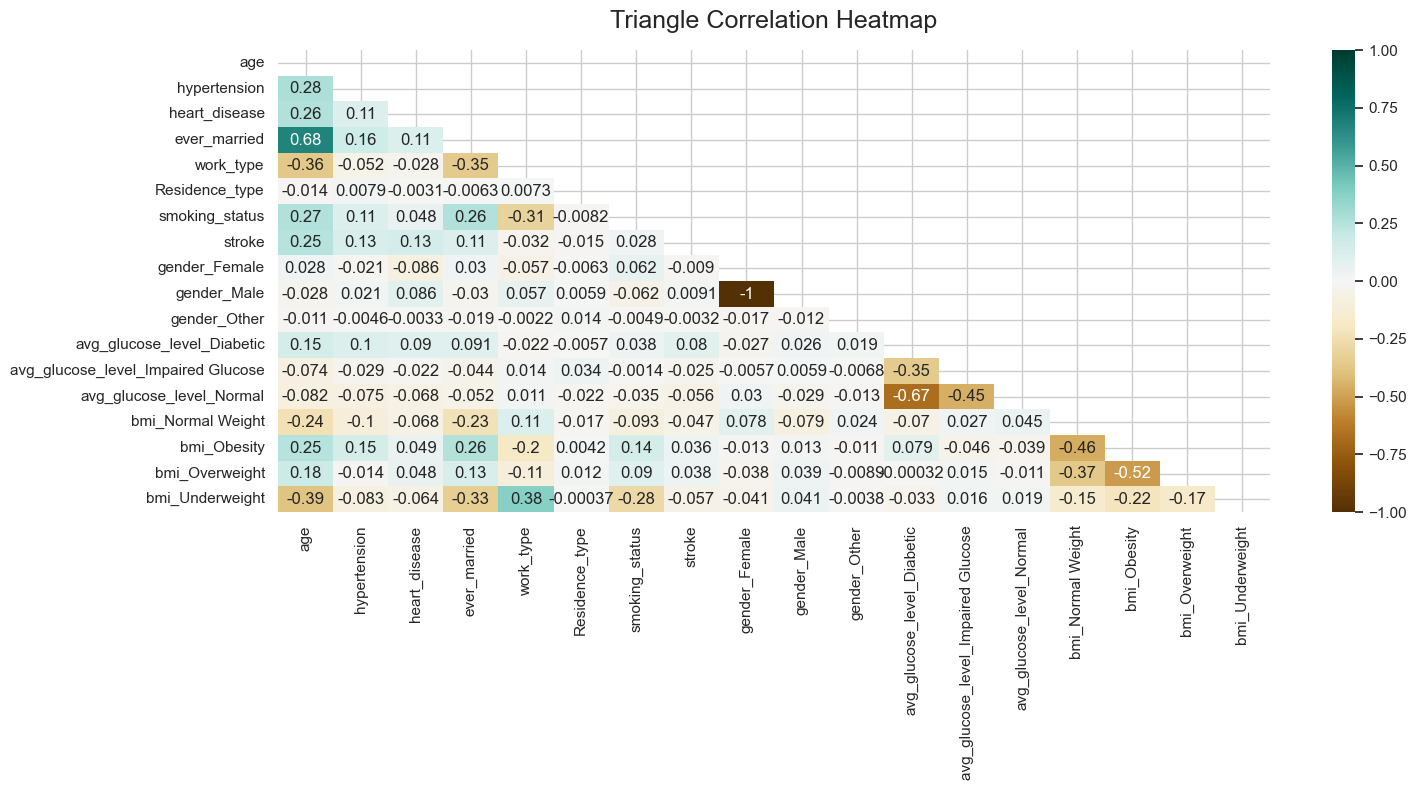

In [287]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

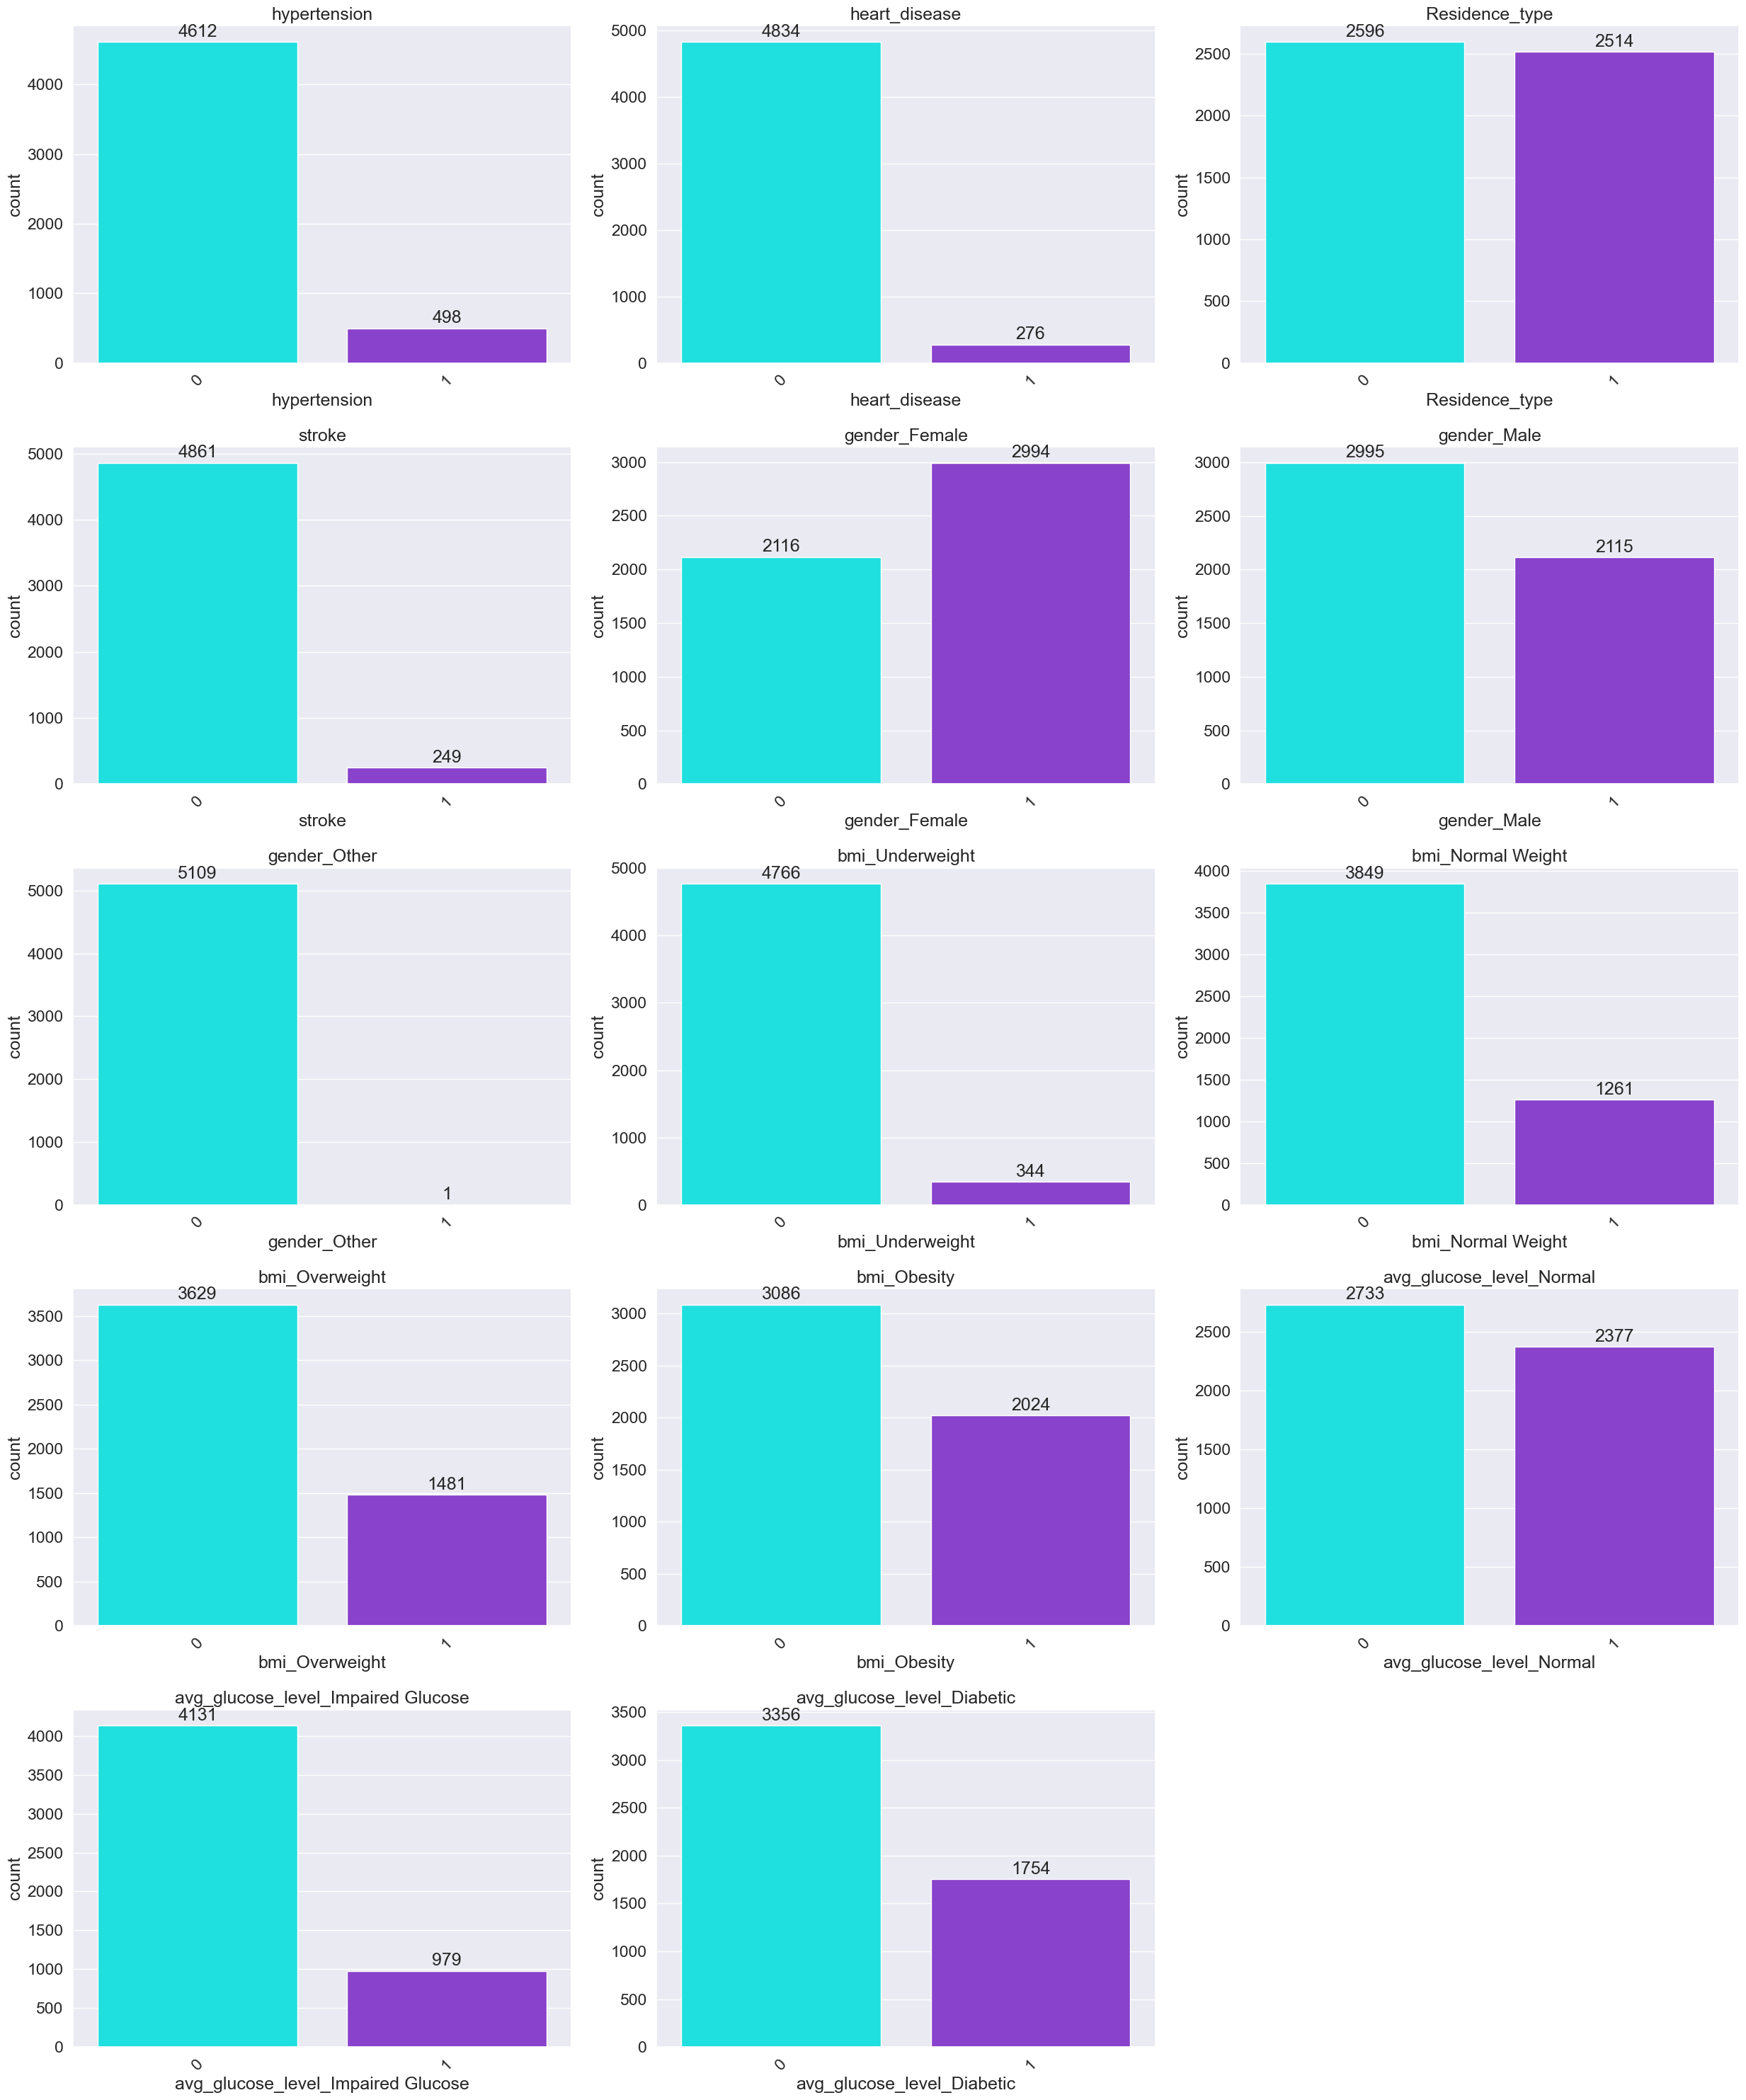

In [288]:
# Identify binary columns
columns_binary = ['hypertension', 'heart_disease', 'Residence_type', 'stroke', 'gender_Female', 'gender_Male', 'gender_Other',
                  'bmi_Underweight', 'bmi_Normal Weight', 'bmi_Overweight', 'bmi_Obesity',  
                  'avg_glucose_level_Normal', 'avg_glucose_level_Impaired Glucose', 'avg_glucose_level_Diabetic']

df_binary = df[columns_binary]

# Plot count plots for df_categorical
a = 5  # number of rows
b = 3  # number of columns
c = 1  # plot counter

fig = plt.figure(figsize=(25, 30))
plt.subplots_adjust(hspace=2)
sns.set(font_scale=1.5)

for i in columns_binary:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    
    sns.countplot(data=df_binary, x=i, palette=['aqua', 'blueviolet'])
    
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
    plt.xticks(rotation=45)
    c += 1

fig.tight_layout()
plt.show()


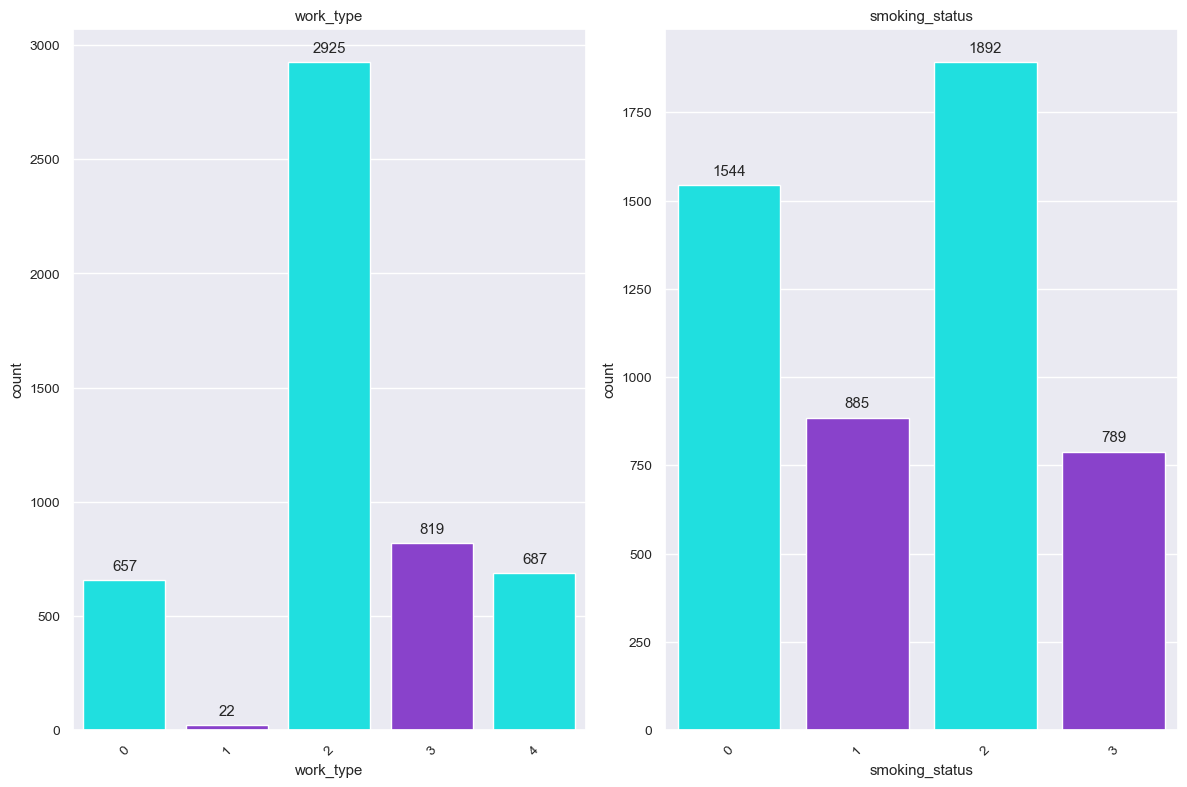

In [289]:
# Identify categorical columns
columns_categorical = ['work_type', 'smoking_status']
df_categorical = df[columns_categorical]

# Plot count plots for df_categorical
a = 1  # number of rows
b = 2  # number of columns
c = 1  # plot counter

fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=2)
sns.set(font_scale=0.9)

for i in columns_categorical:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    
    sns.countplot(data=df_categorical, x=i, palette=['aqua', 'blueviolet'])
    
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
    plt.xticks(rotation=45)
    c += 1

fig.tight_layout()
plt.show()


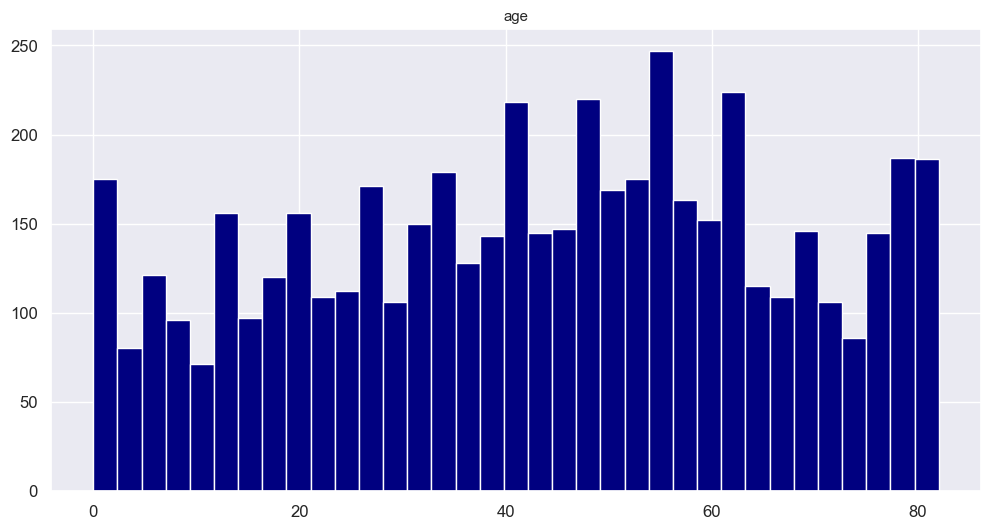

In [290]:
df[['age']].hist(figsize=(12, 6), bins=35, xlabelsize=12, ylabelsize=12, color="navy");

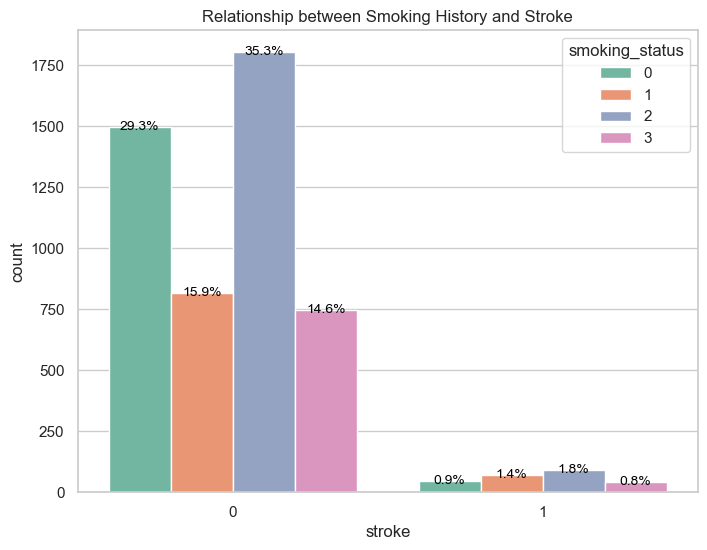

In [291]:
# Label Mapping:
# {'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df['stroke'], hue=df['smoking_status'], palette="Set2")

plt.title('Relationship between Smoking History and Stroke')

# Annotate with percentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')

plt.show()

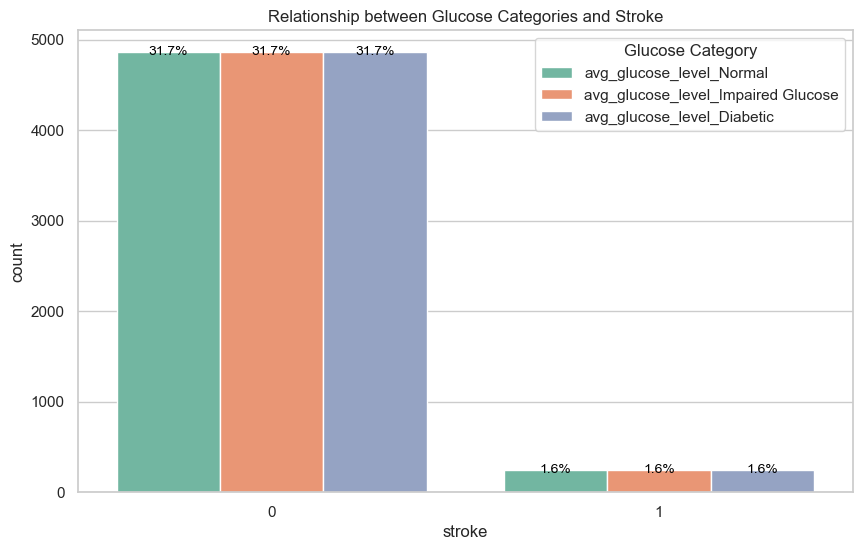

In [292]:
glucose_columns = ['avg_glucose_level_Normal', 'avg_glucose_level_Impaired Glucose', 'avg_glucose_level_Diabetic']
df_glucose = df[glucose_columns + ['stroke']]

# Melt the DataFrame
df_glucose_melted = pd.melt(df_glucose, id_vars='stroke', var_name='Glucose Category', value_name='Count')

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='stroke', hue='Glucose Category', data=df_glucose_melted, palette='Set2')
plt.title('Relationship between Glucose Categories and Stroke')

# Add percentage annotations
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df_glucose_melted))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')

plt.show()


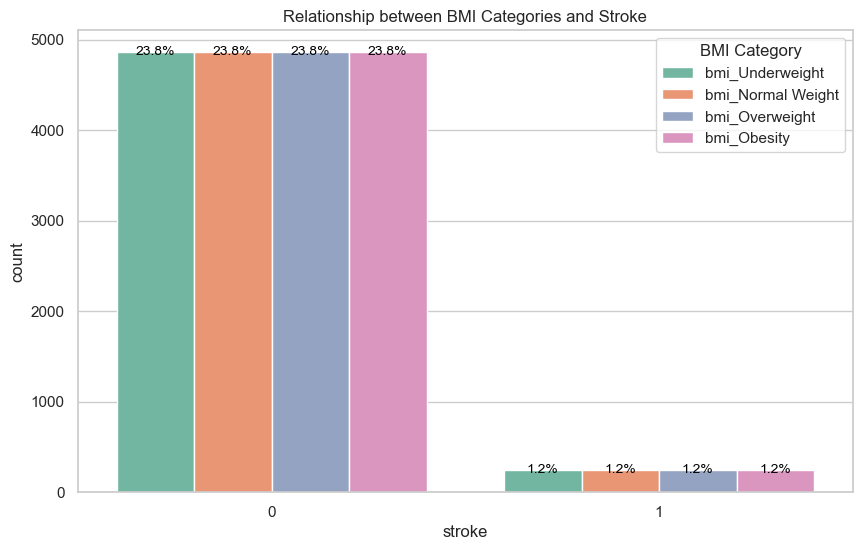

In [293]:
bmi_columns = ['bmi_Underweight', 'bmi_Normal Weight', 'bmi_Overweight', 'bmi_Obesity']
df_bmi = df[bmi_columns + ['stroke']]

df_bmi_melted = pd.melt(df_bmi, id_vars='stroke', var_name='BMI Category', value_name='Count')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='stroke', hue='BMI Category', data=df_bmi_melted, palette='Set2')
plt.title('Relationship between BMI Categories and Stroke')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df_bmi_melted))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')

plt.show()

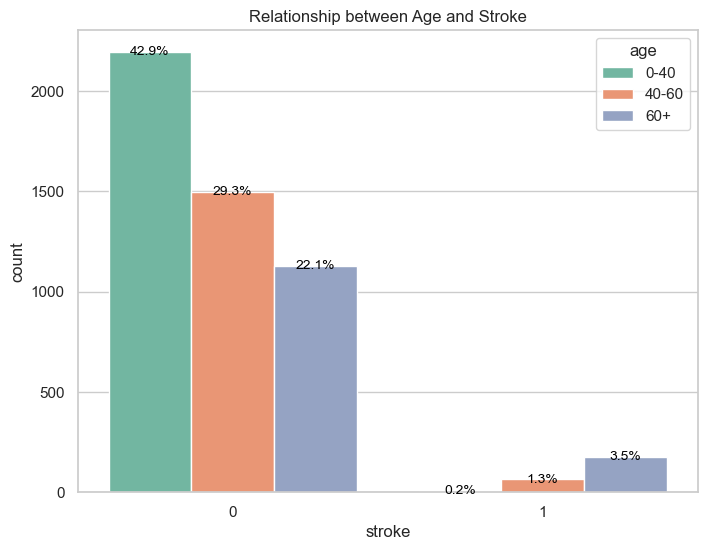

In [294]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df['stroke'], hue=pd.cut(df['age'], bins=[0, 40, 60, float('inf')], labels=['0-40', '40-60', '60+']), palette="Set2")

plt.title('Relationship between Age and Stroke')


for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')

plt.show()


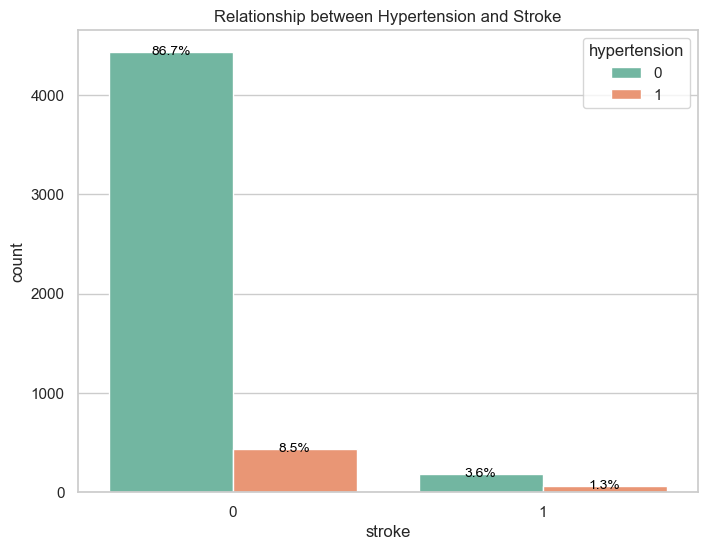

In [295]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df['stroke'], hue=df['hypertension'], palette="Set2")

plt.title('Relationship between Hypertension and Stroke')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')

plt.show()

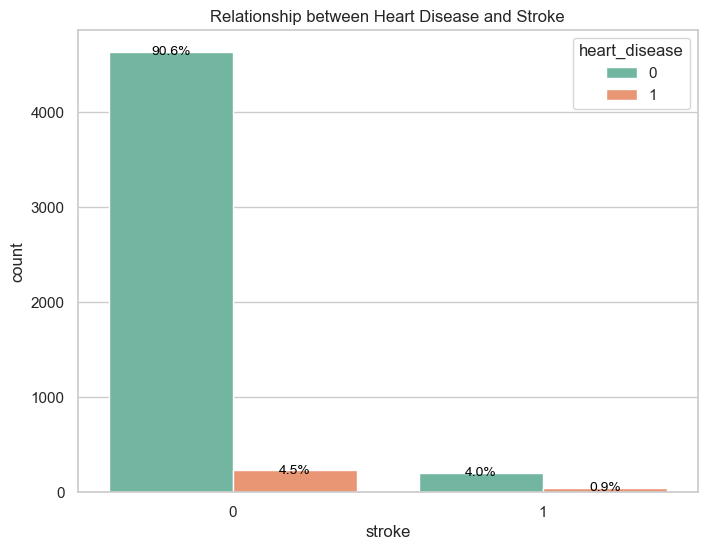

In [296]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df['stroke'], hue=df['heart_disease'], palette="Set2")

plt.title('Relationship between Heart Disease and Stroke')

# Annotate with percentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')

plt.show()

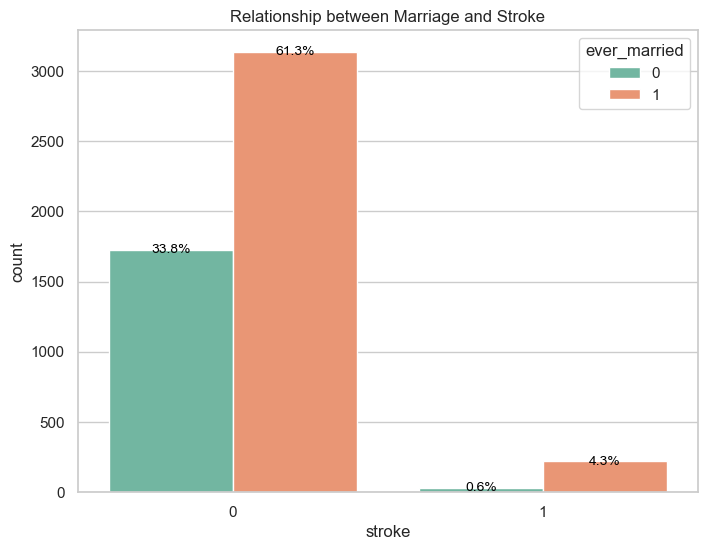

In [297]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df['stroke'], hue=df['ever_married'], palette="Set2")

plt.title('Relationship between Marriage and Stroke')

# Annotate with percentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')

plt.show()

## Outliers

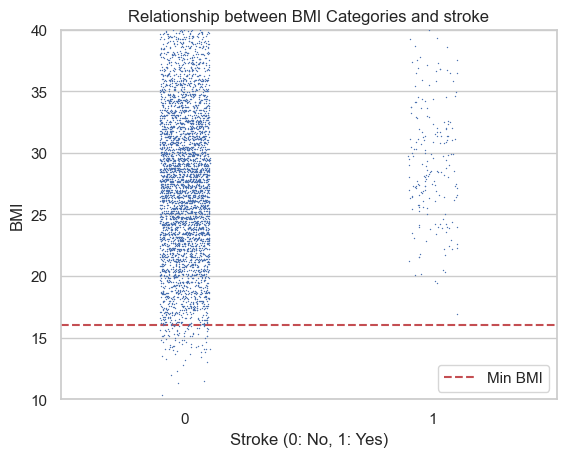

In [298]:
# Strip plot using Seaborn
sns.stripplot(x='stroke', y='bmi', data=df2, jitter=True, s=1, legend="full")
plt.axhline(y=16, color='r', linestyle='--', label='Min BMI')

# Add labels and title
plt.xlabel('Stroke (0: No, 1: Yes)')
plt.ylabel('BMI')
plt.title('Relationship between BMI Categories and stroke')

# Set the y-axis limits to display a broader range of numbers
plt.ylim(10, 40)

# Show the plot
plt.legend()
plt.show()

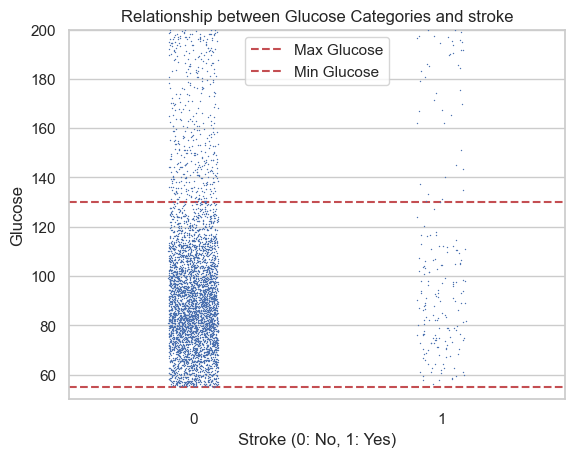

In [301]:
# Strip plot using Seaborn
sns.stripplot(x='stroke', y='avg_glucose_level', data=df2, jitter=True, s=1, legend="full")
plt.axhline(y=130, color='r', linestyle='--', label='Max Glucose')
plt.axhline(y=55, color='r', linestyle='--', label='Min Glucose')

# Add labels and title
plt.xlabel('Stroke (0: No, 1: Yes)')
plt.ylabel('Glucose')
plt.title('Relationship between Glucose Categories and stroke')

# Set the y-axis limits to display a broader range of numbers
plt.ylim(50, 200)

# Show the plot
plt.legend()
plt.show()

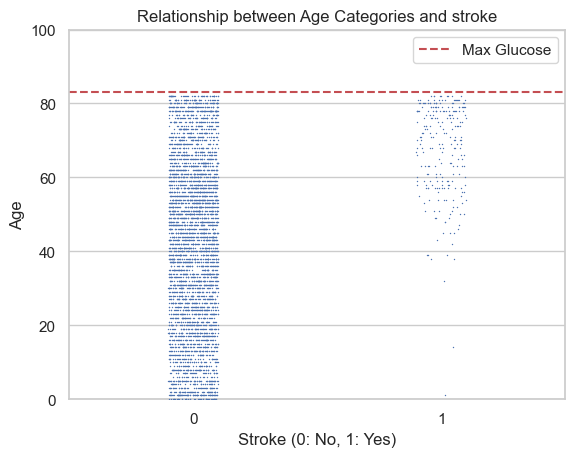

In [304]:
sns.stripplot(x='stroke', y='age', data=df, jitter=True, s=1, legend="full")
plt.axhline(y=83, color='r', linestyle='--', label='Max Glucose')

# Add labels and title
plt.xlabel('Stroke (0: No, 1: Yes)')
plt.ylabel('Age')
plt.title('Relationship between Age Categories and stroke')

# Set the y-axis limits to display a broader range of numbers
plt.ylim(0, 100)

# Show the plot
plt.legend()
plt.show()

## SweetViz

In [306]:
sweet_report = sv.analyze(df)
sweet_report.show_html('healthcare-dataset-stroke-data_sweet_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report healthcare-dataset-stroke-data_sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Model Selection

In [308]:
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [309]:
models = [
    LogisticRegression(), 
    SVC(),
    DecisionTreeClassifier(random_state=40,min_samples_leaf=2), 
   RandomForestClassifier(n_estimators=100,min_samples_leaf=2), 
    AdaBoostClassifier(), 
    GradientBoostingClassifier(), 
    xgb.XGBClassifier(base_score=0.3)
]

In [310]:
def run_models(models, X_train, X_test, y_train, y_test):
    results = []
    
    for model in models:
        model_name = type(model).__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)
        
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Classification Report': classification_rep
        })
    
    return results

# Run the models
results = run_models(models, X_train, X_test, y_train, y_test)

# Display the results
for result in results:
    print(f"Model: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.2f}")
    print("Classification Report:")
    print(result['Classification Report'])
    print('--' * 40)


Model: LogisticRegression
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533

--------------------------------------------------------------------------------
Model: SVC
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533

--------------------------------------------------------------------------------
Model: DecisionTreeClassifier
Accuracy: 0.92
Classification Report:
   

# Imbalanced Techniques

In [311]:
imbalanced_techniques = [
    RandomOverSampler(),
    RandomUnderSampler(),
    SMOTE(),
    SMOTETomek()
]

In [312]:
def run_models_with_imbalance(X_train, X_test, y_train, y_test, models, imbalance_methods):
    results2 = []
    
    for model in models:
        for imbalance_method in imbalance_methods:
            model_name = type(model).__name__
            imbalance_name = type(imbalance_method).__name__

            # Build a Pipeline with Class Imbalance Handling and Classifier
            model_pipeline = Pipeline([
                ('scaler', StandardScaler()),  # Example: StandardScaler for feature scaling
                ('sampler', imbalance_method),
                ('classifier', model)
            ])

            # Train the Pipeline
            model_pipeline.fit(X_train, y_train)

            # Evaluate on the test set
            y_pred = model_pipeline.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            classification_rep = classification_report(y_test, y_pred)

            print(f"Model: {model_name}, Imbalance Technique: {imbalance_name}")
            print(f"Accuracy: {accuracy:.2f}")
            print("Classification Report:")
            print(classification_rep)
            print('--' * 40)
            
            
results2 = run_models_with_imbalance(X_train, X_test, y_train, y_test, models, imbalanced_techniques)

if results2 is not None:
    for result in results2:
        print(f"Model: {result['Model']}")
        print(f"Imbalance Technique: {result['Imbalance Technique']}")
        print(f"Accuracy: {result['Accuracy']:.2f}")
        print("Classification Report:")
        print(result['Classification Report'])
        print('--' * 40)
else:
    print("No results to display.")

Model: LogisticRegression, Imbalance Technique: RandomOverSampler
Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1444
           1       0.15      0.74      0.25        89

    accuracy                           0.74      1533
   macro avg       0.56      0.74      0.54      1533
weighted avg       0.93      0.74      0.81      1533

--------------------------------------------------------------------------------
Model: LogisticRegression, Imbalance Technique: RandomUnderSampler
Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1444
           1       0.15      0.74      0.25        89

    accuracy                           0.74      1533
   macro avg       0.56      0.74      0.54      1533
weighted avg       0.93      0.74      0.81      1533

--------------------------------------------------------

Model: AdaBoostClassifier, Imbalance Technique: SMOTE
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1444
           1       0.22      0.43      0.29        89

    accuracy                           0.88      1533
   macro avg       0.59      0.67      0.61      1533
weighted avg       0.92      0.88      0.90      1533

--------------------------------------------------------------------------------
Model: AdaBoostClassifier, Imbalance Technique: SMOTETomek
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1444
           1       0.19      0.39      0.26        89

    accuracy                           0.87      1533
   macro avg       0.58      0.65      0.59      1533
weighted avg       0.92      0.87      0.89      1533

----------------------------------------------------------------------------

## Pickle

In [313]:
smote = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [314]:
df_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
df_train_smote['Stroke'] = y_train_smote

df_train_smote.to_pickle("df_train_stroke.pkl")

In [315]:
df_test = X_test.copy()
df_test['Stroke'] = y_test  

df_test.to_pickle("df_train_stroke.pkl")

## Get the Data

In [316]:
loaded_df_train = pd.read_pickle("df_train_stroke.pkl")
loaded_df_test = pd.read_pickle("df_train_stroke.pkl")

In [317]:
loaded_df_test.head()

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,gender_Female,gender_Male,gender_Other,avg_glucose_level_Diabetic,avg_glucose_level_Impaired Glucose,avg_glucose_level_Normal,bmi_Normal Weight,bmi_Obesity,bmi_Overweight,bmi_Underweight,Stroke
4688,31,0,0,0,3,1,0,0,1,0,1,0,0,1,0,0,0,0
4478,40,0,0,1,3,1,2,0,1,0,1,0,0,0,0,1,0,0
3849,8,0,0,0,4,0,0,1,0,0,0,0,1,1,0,0,0,0
4355,79,1,0,1,3,1,2,1,0,0,0,0,1,1,0,0,0,0
3826,75,0,0,1,0,1,2,1,0,0,0,0,1,0,0,1,0,0


## Train Test Split

In [318]:
X_train = loaded_df_train.loc[:,loaded_df_train.columns != 'Stroke']
y_train = loaded_df_train['Stroke']
X_test = loaded_df_test.loc[:,loaded_df_test.columns != 'Stroke']
y_test = loaded_df_test['Stroke']

In [319]:
def run_models(models, X_train, X_test, y_train, y_test):
    results = []
    
    for model in models:
        model_name = type(model).__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)
        
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Classification Report': classification_rep
        })
    
    return results

# Run the models
results = run_models(models, X_train, X_test, y_train, y_test)

# Display the results
for result in results:
    print(f"Model: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.2f}")
    print("Classification Report:")
    print(result['Classification Report'])
    print('--' * 40)


Model: LogisticRegression
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533

--------------------------------------------------------------------------------
Model: SVC
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533

--------------------------------------------------------------------------------
Model: DecisionTreeClassifier
Accuracy: 0.97
Classification Report:
   

## Gridsearch

In [ ]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 1.0],
#     'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
# }

In [ ]:
# grid = GridSearchCV(AdaBoostClassifier(), param_grid, refit=True, verbose=3)

## --------------------------------------------------------------------------------

# Gridsearch

In [ ]:
# Assuming you have your data (X, y) ready
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
model = LogisticRegression()

# Define the hyperparameter grid to search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Create GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
pred = best_model.predict(X_test)

# Display the classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, pred))


In [ ]:
# # Assuming you have your data (X, y) ready
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the hyperparameter grid to search
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     'kernel': ['rbf', 'linear', 'poly']
# }

# # Create GridSearchCV object
# grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

# # Fit the model to the training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print("Best Parameters: ", grid_search.best_params_)

# # Print the best estimator
# print("Best Estimator: ", grid_search.best_estimator_)

# # Make predictions on the test set using the best model
# grid_predictions = grid_search.predict(X_test)

# # Display the classification report
# print("Classification Report:")
# print(classification_report(y_test, grid_predictions))
